# Working with histology images

My goal is to generate patches and save them to disk. Perhaps also compare between saving to PNG or HDF5.

See the [Aachen Protocol for deep learning histopathology](https://zenodo.org/record/3694994). Kather lab uses this.

See girder's [large_image](https://digitalslidearchive.github.io/HistomicsTK/examples/using_large_image.html) and [histomicsTK](https://digitalslidearchive.github.io/HistomicsTK/examples/using_large_image.html).

# Use openslide to get tiles

In [1]:
# for nice style
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path
from typing import List, NamedTuple, Tuple, Union

import openslide
import PIL

PathType = Union[Path, str]

<IPython.core.display.Javascript object>

In [3]:
def get_num_tiles(
    slide_size: Tuple[int, int],
    tile_size: Tuple[int, int],
    strides: Tuple[int, int] = None,
) -> Tuple[int, int]:
    """Get number of tiles that can be taken from a whole slide.

    Does not include partial tiles (e.g., at edges).
    """

    def f(slide, tile, stride):
        return (slide - tile) // stride + 1

    # By default, no overlap.
    strides = strides or tile_size
    num_tiles_w = f(slide_size[0], tile_size[0], strides[0])
    num_tiles_h = f(slide_size[1], tile_size[1], strides[1])
    return num_tiles_w, num_tiles_h

<IPython.core.display.Javascript object>

In [4]:
class TileMeta(NamedTuple):
    """Metadata for one tile.

    Used to save tiles to disk as images.
    """

    oslide: openslide.OpenSlide
    wsi_id: str
    i: int
    j: int
    w: int
    h: int
    level: int
    tile_path: Path

    @property
    def filepath(self) -> Path:
        f = f"wsi-{self.wsi_id}_posi-{self.i:07d}_posj-{self.j:07d}_level-{self.level:02d}.png"
        return self.tile_path / f

    def as_pil_image(self) -> PIL.Image.Image:
        img = self.oslide.read_region(
            location=(self.i, self.j),
            level=self.level,
            size=(self.w, self.h),
        )
        return img

<IPython.core.display.Javascript object>

In [5]:
def get_tilemetas(
    oslide: openslide.OpenSlide,
    wsi_id: str,
    level: int,
    tile_size: Tuple[int, int],
    strides: Tuple[int, int] = None,
    tile_path: PathType = Path("tiles"),
) -> List[TileMeta]:
    num_tiles_w, num_tiles_h = get_num_tiles(
        slide_size=oslide.dimensions, tile_size=tile_size, strides=strides
    )
    # Get position for each tile (top-left).
    i_s = list(range(0, oslide.dimensions[0], strides[0]))
    j_s = list(range(0, oslide.dimensions[1], strides[1]))
    i_s = i_s[:num_tiles_w]
    j_s = j_s[:num_tiles_h]

    # sanity check that last tile does not go past slide dimensions.
    assert (i_s[-1] + tile_size[0]) <= oslide.dimensions[0]
    assert (j_s[-1] + tile_size[1]) <= oslide.dimensions[1]

    # i changes most frequently.
    # this means we read i,j left to right, row by row.
    all_ij = [(i, j) for j in j_s for i in i_s]
    assert num_tiles_w * num_tiles_h == len(all_ij)

    all_tm = [
        TileMeta(
            oslide=oslide,
            wsi_id=wsi_id,
            i=ij[0],
            j=ij[1],
            w=tile_size[0],
            h=tile_size[1],
            level=level,
            tile_path=Path(tile_path),
        )
        for ij in all_ij
    ]
    return all_tm

<IPython.core.display.Javascript object>

In [6]:
# todo: how do I know the correct level???
# look into large_image?
# see https://github.com/girder/large_image/blob/cbe308120ff194904654cbd05839267d1a0ba78b/large_image/tilesource/base.py#L1972-L2023

<IPython.core.display.Javascript object>

In [7]:
def save_one(tilemeta: TileMeta) -> bool:
    """Save one tile to disk as an image.

    Return success status. False if file already exists.
    """
    # sanity check... make sure we are not overwriting images
    if tilemeta.filepath.exists():
        return False
    img = tilemeta.as_pil_image()
    img.save(tilemeta.filepath)
    return True

<IPython.core.display.Javascript object>

In [8]:
# Whole slide image from
# https://data.kitware.com/api/v1/file/5899dd6d8d777f07219fcb23/download
ssxx = openslide.OpenSlide(
    "TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7.svs"
)

<IPython.core.display.Javascript object>

In [9]:
all_tms = get_tilemetas(
    oslide=ssxx,
    wsi_id="foo",
    level=0,
    tile_size=(512, 512),
    strides=(512, 512),
    tile_path="tiles",
)

<IPython.core.display.Javascript object>

In [10]:
print(len(all_tms), "tiles")

4650 tiles


<IPython.core.display.Javascript object>

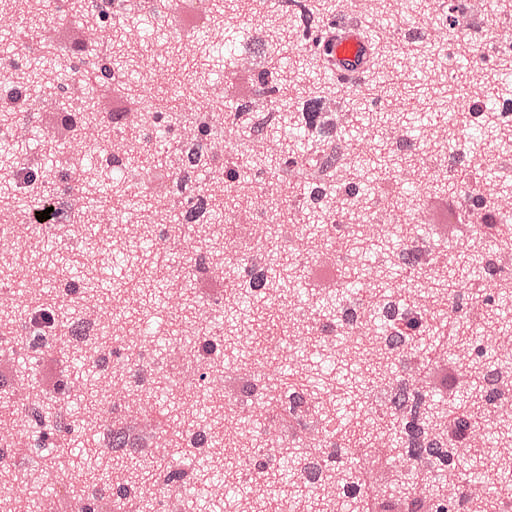

<IPython.core.display.Javascript object>

In [11]:
all_tms[200].as_pil_image()

## Save tiles to disc synchronously

In [ ]:
!mkdir -p tiles

In [ ]:
import time

t0 = time.time()
results = []
num_tms = len(all_tms)
for i, tm in enumerate(all_tms[:100]):
    res = save_one(tm)
    results.append(res)
    print(f"{(i+1)/num_tms:0.02f} % completed", end="\r")
print()
print(f"took {time.time() - t0:0.02f} seconds.")

## Save tiles to disc asynchronously (multiple processes)

Doesn't work because of pointers in ctypes object (probably openslide object).

In [ ]:
import multiprocessing as mp

In [ ]:
with mp.Pool(processes=4) as pool:
    results = pool.map(save_one, all_tms[:100])

In [ ]:
# oh no... probably the openslide object. but we need that...

## Plot gridlines to see tiles

In [12]:
def get_grid_on_thumb(
    oslide: openslide.OpenSlide,
    tile_size: Tuple[int, int],
    strides: Tuple[int, int] = None,
    thumb_size: Tuple[int, int] = (512, 512),
) -> PIL.Image.Image:
    """Return thumbnail of slide with gridlines indicating tiles."""
    import PIL.ImageDraw

    strides = strides or tile_size
    num_tiles_w, num_tiles_h = get_num_tiles(oslide.dimensions, tile_size)
    thumb = oslide.get_thumbnail(thumb_size)
    factor_w = thumb.size[0] / oslide.dimensions[0]
    factor_h = thumb.size[1] / oslide.dimensions[1]

    max_w = (num_tiles_w) * tile_size[0] * factor_w
    max_h = (num_tiles_h) * tile_size[1] * factor_h

    draw = PIL.ImageDraw.Draw(thumb)

    # vertical lines
    for i in range(num_tiles_w + 1):
        i = i * factor_w * tile_size[0]
        draw.line((i, 0, i, max_h), fill=0, width=1)

    # horizontal lines
    for j in range(num_tiles_h + 1):
        j = j * factor_h * tile_size[1]
        draw.line((0, j, max_w, j), fill=0, width=1)

    return thumb

<IPython.core.display.Javascript object>

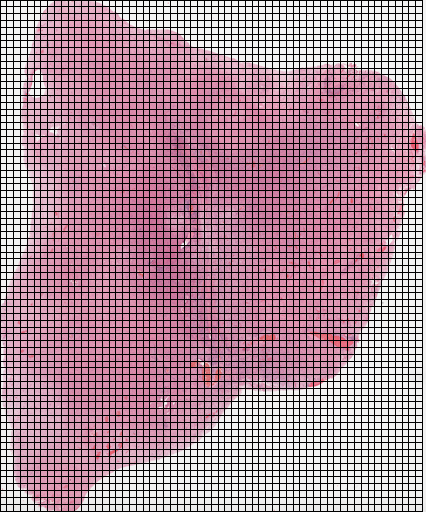

<IPython.core.display.Javascript object>

In [13]:
get_grid_on_thumb(ssxx, tile_size=(512, 512))